In [2]:
import torch
import os
import sys
import pickle
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
from numpy import var
import warnings

In [3]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Load the customer churn dataset into dataframe.
bankrupt_df = pd.read_csv('../data/raw/company_bankruptcy.csv')
    
X = bankrupt_df.drop(["Bankrupt?"], axis=1)
Y = bankrupt_df["Bankrupt?"]

over_sample = SMOTE()
X_ros, Y_ros = over_sample.fit_resample(X, Y)

# we split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_ros, Y_ros, test_size=0.2, random_state=42)

K-Means identify Function

In [5]:

# Scale the inputs to have zero mean and unit variance
scaler = StandardScaler()
reg_model = LogisticRegression(max_iter=1000)
reg_model.fit(scaler.fit_transform(X_train), Y_train)

LogisticRegression(max_iter=1000)

In [6]:
# Predict the target variable for the testing set
Y_pred = reg_model.predict(scaler.fit_transform(X_test))
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
accuracy, precision, recall, f1

(0.9022727272727272,
 0.8881481481481481,
 0.9180704441041347,
 0.9028614457831325)

In [7]:
# Identify the mispredictions and their associated feature values
data_test = X_test.copy()
data_test["Bankrupt?"] = Y_test
data_test['Prediction'] = Y_pred
mispredictions = data_test[data_test["Bankrupt?"] != data_test['Prediction']]

In [8]:
# Use the elbow method to determine the optimal number of clusters
mispredictions_array = mispredictions.drop(["Bankrupt?", 'Prediction'], axis=1).values
distortions = []
for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans.fit(mispredictions_array)
    distortions.append(kmeans.inertia_)

# Select the optimal number of clusters based on the elbow method
best_n_clusters = 0
best_distortion = float('inf')
for i in range(len(distortions) - 1):
    if abs(distortions[i] - distortions[i + 1]) < best_distortion:
        best_n_clusters = i + 2
        best_distortion = abs(distortions[i] - distortions[i + 1])

# Use the optimal number of clusters determined by the elbow method
n_clusters = best_n_clusters

In [9]:
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

In [10]:
# Use k-means clustering to identify groups of similar customers
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
clusters = kmeans.fit_predict(mispredictions.drop(["Bankrupt?", 'Prediction'], axis=1))

# Use SelectKBest to identify the important features
for i in range(n_clusters):
    cluster_data = mispredictions[clusters == i].drop(["Bankrupt?", 'Prediction'], axis=1)
    X = cluster_data.values
    Y = data_test[data_test["Bankrupt?"] != data_test['Prediction']]["Bankrupt?"][clusters == i]

    # Remove constant features
    constant_features = [j for j, column in enumerate(X.T) if var(column) == 0]
    X = np.delete(X, constant_features, axis=1)
    cluster_data = cluster_data.drop(cluster_data.columns[constant_features], axis=1)

    if X.shape[1] == 0:
        print("All features are constant in this cluster")
    else:
        selector = SelectKBest(f_classif, k=1)
        selector = selector.fit(X, Y)
        mask = selector.get_support()            
        important_features = cluster_data.columns[mask]

        # Make changes to the predictive model by removing the least important features
        X_train_new = X_train.drop(important_features, axis=1)
        X_test_new = X_test.drop(important_features, axis=1)

        model_new = LogisticRegression(max_iter=1000)
        model_new.fit(scaler.fit_transform(X_train_new), Y_train)

        Y_pred_new = model_new.predict(scaler.fit_transform(X_test_new))
        accuracy_new = accuracy_score(Y_test, Y_pred_new)
        accuracy_dict.update({i: accuracy_new})
        precision_new = precision_score(Y_test, Y_pred_new)
        precision_dict.update({i: precision_new})
        recall_new = recall_score(Y_test, Y_pred_new)
        recall_dict.update({i: recall_new})
        f1_new = f1_score(Y_test, Y_pred_new)
        f1_dict.update({i: f1_new})

In [11]:
max_accuracy = max(accuracy_dict.values())
print('The max accuracy we could get is', max_accuracy)

max_precision = max(precision_dict.values())
print('The max precision we could get is', max_precision)

max_recall = max(recall_dict.values())
print('The max recall we could get is', max_recall)

max_f = max(f1_dict.values())
print('The max f1 we could get is', max_f)

print('We gain a better accuracy of the model of', (max_accuracy - accuracy) * 100, '%')
print('We gain a better precision of the model of', (max_precision - precision) * 100, '%')
print('We gain a better recall of the model of', (max_recall - recall) * 100, '%')
print('We gain a better f1 score of the model of', (max_f - f1) * 100, '%')

The max accuracy we could get is 0.9068181818181819
The max precision we could get is 0.8978978978978979
The max recall we could get is 0.9226646248085758
The max f1 we could get is 0.9070380127963868
We gain a better accuracy of the model of 0.454545454545463 %
We gain a better precision of the model of 0.9749749749749737 %
We gain a better recall of the model of 0.45941807044410643 %
We gain a better f1 score of the model of 0.41765670132543065 %


PyTorch optimize neural function

In [25]:
# Use PyTorch to optimize the model parameters and improve the accuracy of the predictions
num_epochs = 100
learning_rate = 0.01
input_size = X_train.shape[1]
hidden_size = 10
output_size = 1

In [47]:
# Scale the inputs to have zero mean and unit variance
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

In [50]:
# Convert the data to PyTorch tensors
X_tr = torch.tensor(X_tr, dtype=torch.float32)
Y_tr = torch.tensor(Y_train, dtype=torch.float32)
X_te = torch.tensor(X_te, dtype=torch.float32)
Y_te = torch.tensor(Y_test, dtype=torch.float32)

In [51]:
model = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, output_size),
        torch.nn.Sigmoid()
    )
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tr)
    Y_tr = Y_tr.view(-1, 1)
    loss = criterion(outputs, Y_tr)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [53]:
# Use the trained model to make predictions on the test set
test_outputs = model(X_te)
Y_te = Y_te.view(-1, 1)

# Evaluate the performance of the model using accuracy and other metrics
test_predictions = (test_outputs.detach().numpy() > 0.5).astype(int)
test_actuals = Y_te.detach().numpy().astype(int)
accuracy = accuracy_score(test_actuals, test_predictions)
precision = precision_score(test_actuals, test_predictions, zero_division=1)
recall = recall_score(test_actuals, test_predictions)
f1 = f1_score(test_actuals, test_predictions)
print(
        'Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}'.format(accuracy, precision, recall, f1))


Accuracy: 0.905, Precision: 0.883, Recall: 0.932, F1 score: 0.907


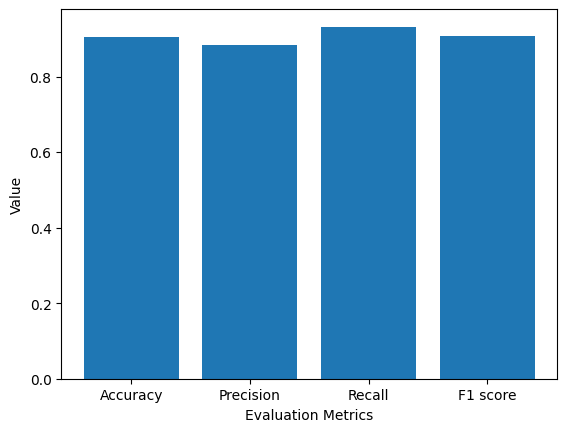

In [54]:
# Create a bar plot of the evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score']
values = [accuracy, precision, recall, f1]
plt.bar(metrics, values)
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.show()



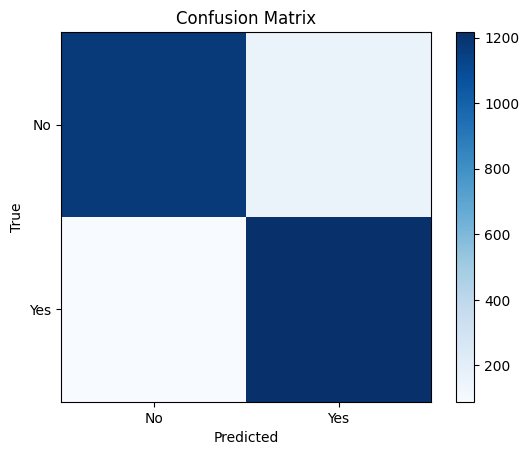

In [55]:
# Calculate the confusion matrix
cm = confusion_matrix(test_actuals, test_predictions)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks([0, 1], ['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



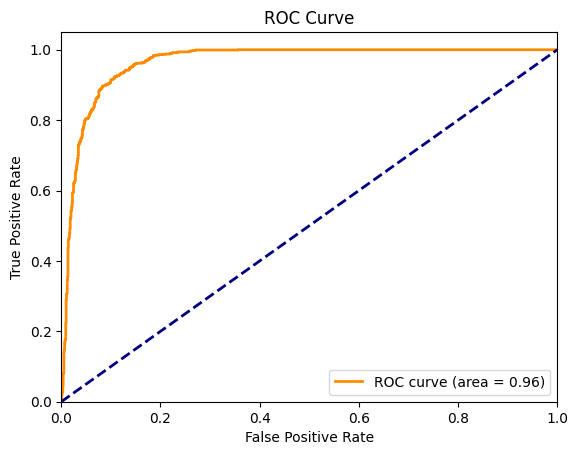

In [56]:
# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_actuals, test_outputs.detach().numpy())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

PyTorch Different Models function

In [34]:

# Define the pipelines for the different models to be compared
pipelines = {
    'lr': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))]),
    'rf': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())]),
    'svc': Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
}

    

In [35]:
# Define the hyperparameters for the different models
hyperparameters = {
    'lr': {'clf__C': [0.1, 1.0, 10.0]},
    'rf': {'clf__n_estimators': [10, 100, 1000]},
    'svc': {'clf__C': [0.1, 1.0, 10.0], 'clf__kernel': ['linear', 'rbf']}
}

In [37]:
# Use PyTorch to compare the performance of the different models using cross-validation
num_folds = 5
results = {}
   
for model_name, pipeline in pipelines.items():
    clf = GridSearchCV(pipeline, hyperparameters[model_name], cv=num_folds, scoring='accuracy')
    clf.fit(X_train, Y_train)
    results[model_name] = {
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'cv_results': clf.cv_results_
    }

    

Model: lr
Best score: 0.9051912421227911
Best params: {'clf__C': 1.0}

Model: rf
Best score: 0.9749953346826867
Best params: {'clf__n_estimators': 1000}

Model: svc
Best score: 0.9737640946413448
Best params: {'clf__C': 10.0, 'clf__kernel': 'rbf'}



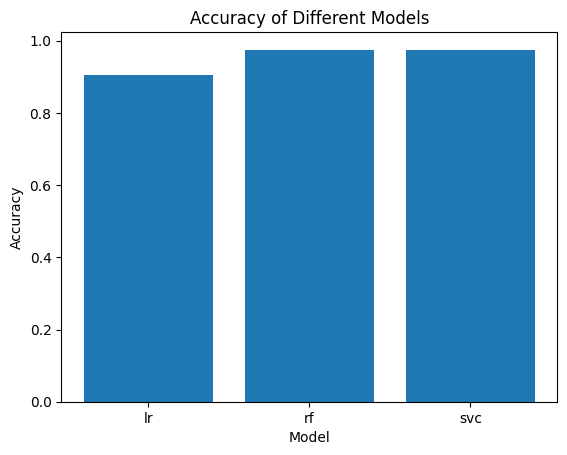

In [38]:
# Print the results for each model
for model_name, result in results.items():
    print('Model:', model_name)
    print('Best score:', result['best_score'])
    print('Best params:', result['best_params'])
    print()

# Visualize the accuracy of the different models
model_names = list(results.keys())
model_scores = [result['best_score'] for result in results.values()]
plt.bar(model_names, model_scores)
plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

PyTorch Visualisation function

In [12]:
# Logistic Regression
# Scale the inputs to have zero mean and unit variance
scaler = StandardScaler()
reg_model = LogisticRegression(max_iter=1000)
reg_model.fit(scaler.fit_transform(X_train), Y_train)

LogisticRegression(max_iter=1000)

In [13]:
# Predict the target variable for the testing set
Y_predd = reg_model.predict(scaler.fit_transform(X_test))
# Convert the predictions and actual outcomes to PyTorch tensors
Y_pred_torch = torch.tensor(Y_predd, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32)

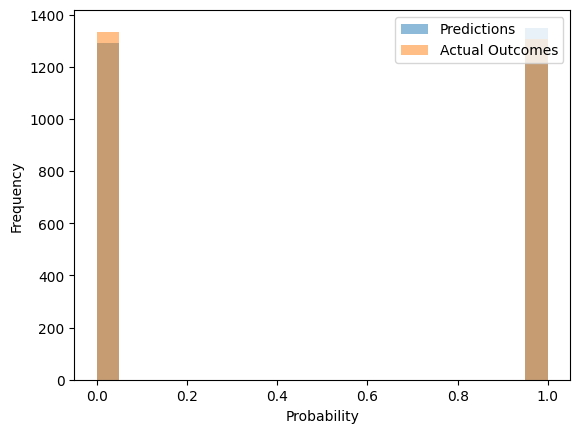

In [14]:
# Plot the distribution of model predictions and actual outcomes, histogram plot
plt.hist(Y_pred_torch.detach().numpy(), bins=20, alpha=0.5, label='Predictions')
plt.hist(Y_test, bins=20, alpha=0.5, label='Actual Outcomes')
plt.legend(loc='upper right')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

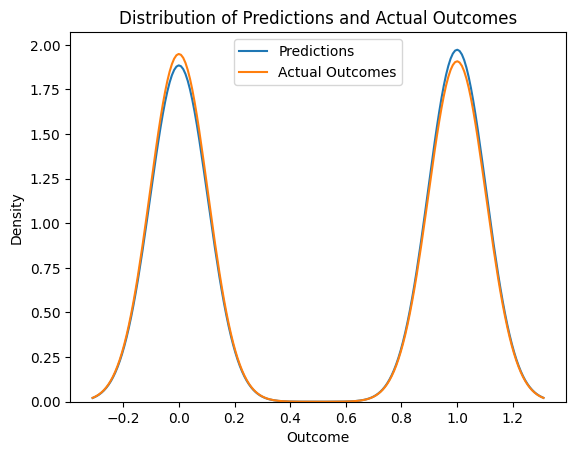

In [16]:
# Plot the distribution of predictions and actual outcomes, kernel density estimate plot
sns.kdeplot(Y_pred_torch.numpy(), label='Predictions')
sns.kdeplot(Y_test, label='Actual Outcomes')
plt.title('Distribution of Predictions and Actual Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.show()